# Experiment: Working with Points Only Data

*   List item
*   List item





In [ ]:
import math
import itertools
import random
import os

import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import scipy.spatial.distance
!pip install scikit-plot
import scikitplot as skplt
import scipy.spatial.distance

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

import plotly.graph_objects as go
import plotly.express as px

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score


!pip install path.py;
from path import Path

random.seed = 42

from google.colab import drive
drive.mount('/content/drive')

PATH = Path("/content/drive/My Drive/KM3Net Data/points/")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
parent_folders = os.listdir(PATH)
folders = [dir for dir in sorted(parent_folders) if os.path.isdir(PATH/dir)]
classes = {folder: i for i, folder in enumerate(folders)};

print("The parent folders: {0}; classes: {1}".format(parent_folders,
                                                     classes))

The parent folders: ['mixed', 'noise']; classes: {'mixed': 0, 'noise': 1}


# Reading `xyz` Files

In [ ]:
def read_xyz(file):
    n_verts = len(file.readlines())
    file.seek(0)
    verts = [[float(s) for s in file.readline().strip().split(' ')] for i in range(n_verts)]
    return verts

In [ ]:
class PointSampler(object):
    def __call__(self, data):
        choice_indices = np.random.choice(len(data), 8192, replace=True)
        choices = [data[i] for i in choice_indices]
        
        return np.array(choices)

    # def __init__(self, output_size):
    #     assert isinstance(output_size, int)
    #     self.output_size = output_size
    
    # def triangle_area(self, pt1, pt2, pt3):
    #     side_a = np.linalg.norm(pt1 - pt2)
    #     side_b = np.linalg.norm(pt2 - pt3)
    #     side_c = np.linalg.norm(pt3 - pt1)
    #     s = 0.5 * ( side_a + side_b + side_c)
    #     return max(s *
    #                (s - side_a) * 
    #                (s - side_b) * 
    #                (s - side_c), 0)**0.5

    # def sample_point(self, pt1, pt2, pt3):
    #     # barycentric coordinates on a triangle
    #     # https://mathworld.wolfram.com/BarycentricCoordinates.html
    #     s, t = sorted([random.random(), random.random()])
    #     f = lambda i: s * pt1[i] + (t-s)*pt2[i] + (1-t)*pt3[i]
    #     return (f(0), f(1), f(2))
        
    
    # def __call__(self, mesh):
    #     verts, faces = mesh
    #     verts = np.array(verts)
    #     areas = np.zeros((len(faces)))

    #     for i in range(len(areas)):
    #         areas[i] = (self.triangle_area(verts[faces[i][0]],
    #                                        verts[faces[i][1]],
    #                                        verts[faces[i][2]]))
            
    #     sampled_faces = (random.choices(faces, 
    #                                   weights=areas,
    #                                   cum_weights=None,
    #                                   k=self.output_size))
        
    #     sampled_points = np.zeros((self.output_size, 3))

    #     for i in range(len(sampled_faces)):
    #         sampled_points[i] = (self.sample_point(verts[sampled_faces[i][0]],
    #                                                verts[sampled_faces[i][1]],
    #                                                verts[sampled_faces[i][2]]))
        
    #     return sampled_points

class Normalize(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape)==2
        
        norm_pointcloud = pointcloud - np.mean(pointcloud, axis=0) 
        norm_pointcloud /= np.max(np.linalg.norm(norm_pointcloud, axis=1))

        return  norm_pointcloud

class RandRotation_z(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape)==2

        theta = random.random() * 2. * math.pi
        rot_matrix = np.array([[ math.cos(theta), -math.sin(theta),    0],
                               [ math.sin(theta),  math.cos(theta),    0],
                               [0,                             0,      1]])
        
        rot_pointcloud = rot_matrix.dot(pointcloud.T).T
        return  rot_pointcloud
    
class RandomNoise(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape)==2

        noise = np.random.normal(0, 0.02, (pointcloud.shape))
    
        noisy_pointcloud = pointcloud + noise
        return  noisy_pointcloud

class ToTensor(object):
    def __call__(self, pointcloud):
        pointcloud = np.array(pointcloud)
        assert len(pointcloud.shape)==2
        return torch.from_numpy(pointcloud)

In [ ]:
def default_transforms():
    return transforms.Compose([PointSampler(),
                               ToTensor()])

In [ ]:
class PointCloudData(Dataset):
    """
    Reads the files in the directory and :
    1. Assigns classes
    2. Checks if it is a training or validation phase
    3. Tags files by it's class
    """
    def __init__(self, root_dir, valid=False, folder="train", transform=default_transforms()):
        self.root_dir = root_dir
        folders = [dir for dir in sorted(os.listdir(root_dir)) if os.path.isdir(root_dir/dir)]
        self.classes = {folder: i for i, folder in enumerate(folders)}
        self.transforms = transform if not valid else default_transforms()
        self.valid = valid
        self.files = []
        for category in self.classes.keys():
            new_dir = root_dir/Path(category)/folder
            for file in os.listdir(new_dir):
                if file.endswith('.xyz'):
                    sample = {}
                    sample['pcd_path'] = new_dir/file
                    sample['category'] = category
                    self.files.append(sample)

    def __len__(self):
        return len(self.files)

    def __preproc__(self, file):
        pointcloud = read_xyz(file)

        if self.transforms:
            pointcloud = self.transforms((pointcloud))
        return pointcloud

    def __getitem__(self, idx):
        pcd_path = self.files[idx]['pcd_path']
        category = self.files[idx]['category']
        with open(pcd_path, 'r') as f:
            pointcloud = self.__preproc__(f)
        return {'pointcloud': pointcloud, 
                'category': self.classes[category]}

In [ ]:
train_transforms = transforms.Compose([PointSampler(),
                    ToTensor()])

In [ ]:
train_ds = PointCloudData(PATH,
                          transform=train_transforms)
valid_ds = PointCloudData(PATH,
                          valid=True,
                          folder='test',
                          transform=train_transforms)

In [ ]:
inv_classes = {i: cat for cat, i in train_ds.classes.items()};
inv_classes

{0: 'mixed', 1: 'noise'}

In [ ]:
print('Train dataset size: ', len(train_ds))
print('Valid dataset size: ', len(valid_ds))
print('Number of classes: ', len(train_ds.classes))
print('Sample pointcloud shape: ', train_ds[0]['pointcloud'].size())
print('Class: ', inv_classes[train_ds[0]['category']])

Train dataset size:  320
Valid dataset size:  80
Number of classes:  2
Sample pointcloud shape:  torch.Size([8192, 3])
Class:  mixed


In [ ]:
train_loader = DataLoader(dataset=train_ds, batch_size=32, shuffle=True)
valid_loader = DataLoader(dataset=valid_ds, batch_size=64)

# Model

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F

class Tnet(nn.Module):
   def __init__(self, k=3):
      super().__init__()
      self.k=k
      self.conv1 = nn.Conv1d(k,64,1)
      self.conv2 = nn.Conv1d(64,128,1)
      self.conv3 = nn.Conv1d(128,1024,1)
      self.fc1 = nn.Linear(1024,512)
      self.fc2 = nn.Linear(512,256)
      self.fc3 = nn.Linear(256,k*k)

      self.bn1 = nn.BatchNorm1d(64)
      self.bn2 = nn.BatchNorm1d(128)
      self.bn3 = nn.BatchNorm1d(1024)
      self.bn4 = nn.BatchNorm1d(512)
      self.bn5 = nn.BatchNorm1d(256)
       

   def forward(self, input):
      # input.shape == (bs,n,3)
      bs = input.size(0)
      xb = F.relu(self.bn1(self.conv1(input)))
      xb = F.relu(self.bn2(self.conv2(xb)))
      xb = F.relu(self.bn3(self.conv3(xb)))
      pool = nn.MaxPool1d(xb.size(-1))(xb)
      flat = nn.Flatten(1)(pool)
      xb = F.relu(self.bn4(self.fc1(flat)))
      xb = F.relu(self.bn5(self.fc2(xb)))
      
      #initialize as identity
      init = torch.eye(self.k, requires_grad=True).repeat(bs,1,1)
      if xb.is_cuda:
        init=init.cuda()
      matrix = self.fc3(xb).view(-1,self.k,self.k) + init
      return matrix


class Transform(nn.Module):
   def __init__(self):
        super().__init__()
        self.input_transform = Tnet(k=3)
        self.feature_transform = Tnet(k=64)
        self.conv1 = nn.Conv1d(3,64,1)

        self.conv2 = nn.Conv1d(64,128,1)
        self.conv3 = nn.Conv1d(128,1024,1)
       

        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
       
   def forward(self, input):
        matrix3x3 = self.input_transform(input)
        # batch matrix multiplication
        xb = torch.bmm(torch.transpose(input,1,2), matrix3x3).transpose(1,2)

        xb = F.relu(self.bn1(self.conv1(xb)))

        matrix64x64 = self.feature_transform(xb)
        xb = torch.bmm(torch.transpose(xb,1,2), matrix64x64).transpose(1,2)

        xb = F.relu(self.bn2(self.conv2(xb)))
        xb = self.bn3(self.conv3(xb))
        xb = nn.MaxPool1d(xb.size(-1))(xb)
        output = nn.Flatten(1)(xb)
        return output, matrix3x3, matrix64x64

class PointNet(nn.Module):
    def __init__(self, classes = 2):
        super().__init__()
        self.transform = Transform()
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, classes)
        

        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(256)
        self.dropout = nn.Dropout(p=0.3)
        self.logsigmoid = nn.LogSigmoid()

    def forward(self, input):
        xb, matrix3x3, matrix64x64 = self.transform(input)
        xb = F.relu(self.bn1(self.fc1(xb)))
        xb = F.relu(self.bn2(self.dropout(self.fc2(xb))))
        output = self.fc3(xb)
        return self.logsigmoid(output), matrix3x3, matrix64x64

In [ ]:
def pointnetloss(outputs, labels, m3x3, m64x64, alpha = 0.0001):
    criterion = torch.nn.NLLLoss()
    bs=outputs.size(0)
    id3x3 = torch.eye(3, requires_grad=True).repeat(bs,1,1)
    id64x64 = torch.eye(64, requires_grad=True).repeat(bs,1,1)
    if outputs.is_cuda:
        id3x3=id3x3.cuda()
        id64x64=id64x64.cuda()
    diff3x3 = id3x3-torch.bmm(m3x3,m3x3.transpose(1,2))
    diff64x64 = id64x64-torch.bmm(m64x64,m64x64.transpose(1,2))
    return criterion(outputs, labels) + alpha * (torch.norm(diff3x3)+torch.norm(diff64x64)) / float(bs)

# Train

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
pointnet = PointNet()
pointnet.to(device)
# print(pointnet)

PointNet(
  (transform): Transform(
    (input_transform): Tnet(
      (conv1): Conv1d(3, 64, kernel_size=(1,), stride=(1,))
      (conv2): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
      (conv3): Conv1d(128, 1024, kernel_size=(1,), stride=(1,))
      (fc1): Linear(in_features=1024, out_features=512, bias=True)
      (fc2): Linear(in_features=512, out_features=256, bias=True)
      (fc3): Linear(in_features=256, out_features=9, bias=True)
      (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn3): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (feature_transform): Tnet(
      (conv1): Conv1d(64, 64, kernel_size=(1,

In [ ]:
optimizer = torch.optim.Adam(pointnet.parameters(), lr=0.001)

In [ ]:
def train(model, train_loader, val_loader=None,  epochs=100, save=True):
    for epoch in range(epochs): 
        pointnet.train()
        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data['pointcloud'].to(device).float(), data['category'].to(device)
            optimizer.zero_grad()
            outputs, m3x3, m64x64 = pointnet(inputs.transpose(1,2))

            loss = pointnetloss(outputs, labels, m3x3, m64x64)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 10 == 9:
                print('[Epoch: %d, Batch: %4d / %4d], loss: %.3f' % 
                      (epoch + 1, i + 1, len(train_loader), running_loss / 10))
                running_loss = 0.0

        pointnet.eval()
        correct = total = 0

        # validation
        if val_loader:
            with torch.no_grad():
                for data in val_loader:
                    inputs, labels = data['pointcloud'].to(device).float(), data['category'].to(device)
                    outputs, __, __ = pointnet(inputs.transpose(1,2))
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
            val_acc = 100. * correct / total
            print('Valid accuracy: %d %%' % val_acc)

        # save the model
        if save:
          torch.save(pointnet.state_dict(),
                     "save_" + str(epoch) + ".pth")

In [ ]:
train(pointnet, train_loader, valid_loader,  save=True)

[Epoch: 1, Batch:   10 /   10], loss: 0.431
Valid accuracy: 63 %
[Epoch: 2, Batch:   10 /   10], loss: 0.163
Valid accuracy: 52 %
[Epoch: 3, Batch:   10 /   10], loss: 0.081
Valid accuracy: 47 %
[Epoch: 4, Batch:   10 /   10], loss: 0.046
Valid accuracy: 50 %
[Epoch: 5, Batch:   10 /   10], loss: 0.032
Valid accuracy: 46 %
[Epoch: 6, Batch:   10 /   10], loss: 0.025
Valid accuracy: 51 %
[Epoch: 7, Batch:   10 /   10], loss: 0.020
Valid accuracy: 51 %
[Epoch: 8, Batch:   10 /   10], loss: 0.017
Valid accuracy: 47 %
[Epoch: 9, Batch:   10 /   10], loss: 0.014
Valid accuracy: 48 %
[Epoch: 10, Batch:   10 /   10], loss: 0.013
Valid accuracy: 50 %
[Epoch: 11, Batch:   10 /   10], loss: 0.011
Valid accuracy: 46 %
[Epoch: 12, Batch:   10 /   10], loss: 0.010
Valid accuracy: 46 %
[Epoch: 13, Batch:   10 /   10], loss: 0.009
Valid accuracy: 46 %
[Epoch: 14, Batch:   10 /   10], loss: 0.008
Valid accuracy: 46 %
[Epoch: 15, Batch:   10 /   10], loss: 0.007
Valid accuracy: 43 %
[Epoch: 16, Batch: 

# Test

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
pointnet = PointNet()
pointnet.load_state_dict(torch.load('save_55.pth'))
pointnet.eval();

In [ ]:
all_preds = []
all_labels = []
with torch.no_grad():
    for i, data in enumerate(valid_loader):
        print('Batch [%4d / %4d]' % (i+1, len(valid_loader)))
                   
        inputs, labels = data['pointcloud'].float(), data['category']
        outputs, __, __ = pointnet(inputs.transpose(1,2))
        _, preds = torch.max(outputs.data, 1)
        all_preds += list(preds.numpy())
        all_labels += list(labels.numpy())

Batch [   1 /    2]
Batch [   2 /    2]


In [ ]:
cm = confusion_matrix(all_labels, all_preds);
cm

array([[28, 12],
       [26, 14]])

In [ ]:
# function from https://deeplizard.com/learn/video/0LhiS6yu2qQ
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Normalized confusion matrix


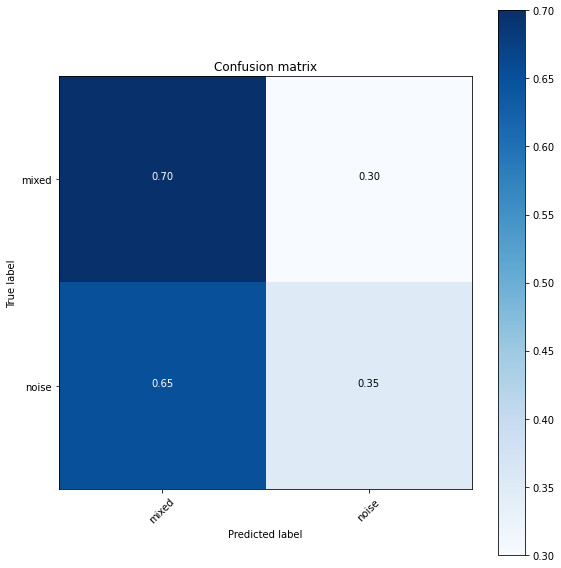

In [ ]:
plt.figure(figsize=(8,8))
plot_confusion_matrix(cm, list(classes.keys()), normalize=True)

Confusion matrix, without normalization


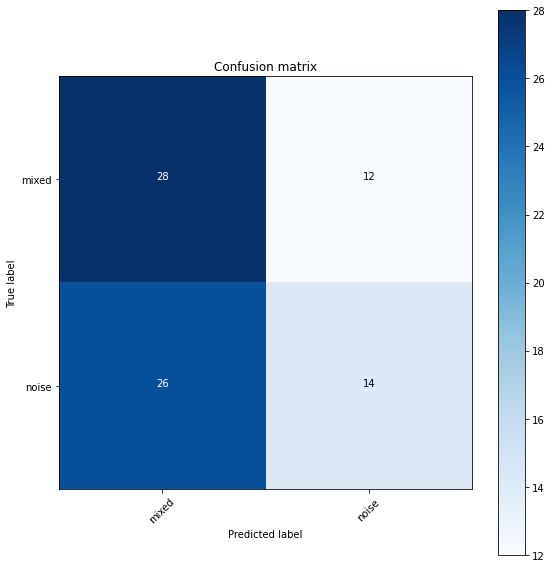

In [ ]:
plt.figure(figsize=(8,8))
plot_confusion_matrix(cm, list(classes.keys()), normalize=False)

Classification report for Pointnet:

               precision    recall  f1-score   support

       mixed       0.52      0.70      0.60        40
       noise       0.54      0.35      0.42        40

    accuracy                           0.53        80
   macro avg       0.53      0.52      0.51        80
weighted avg       0.53      0.53      0.51        80

FPR [0.  0.3 1. ] 
 TPR: [0.   0.35 1.  ] 
 THRESHOLDS: [2 1 0] 



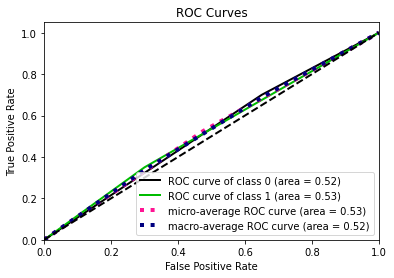

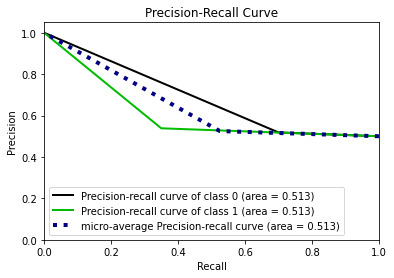

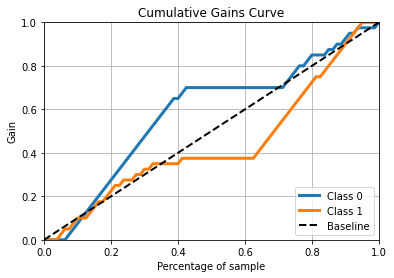

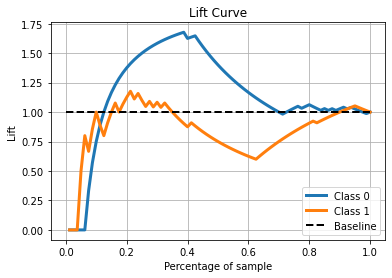

In [ ]:
print("Classification report for Pointnet:\n\n {}".format(classification_report(all_labels,
                                                                            all_preds,
                                                                            target_names=list(classes.keys()))))

roc_auc = roc_auc_score(all_labels, all_preds)
fpr, tpr, thresholds = metrics.roc_curve(all_labels, all_preds)
print("FPR {} \n TPR: {} \n THRESHOLDS: {} \n".format(fpr, tpr, thresholds))

proba = [1 - x for x in all_preds] 
len(all_preds)
skplt.metrics.plot_roc(all_labels, np.column_stack([proba, all_preds]))
plt.show()

skplt.metrics.plot_precision_recall(all_labels,
                                    np.column_stack([proba, all_preds]))
plt.show()

skplt.metrics.plot_cumulative_gain(all_labels,
                                   np.column_stack([proba, all_preds]))
skplt.metrics.plot_lift_curve(all_labels,
                              np.column_stack([proba, all_preds]))